# Convolutional Neural Network for Stock Forecasting

To start, enter the ticker of the stock you want to forecast in the cell below. Go to https://finance.yahoo.com/ for reference.

In [1]:
# stock ticker to visualize
ticker = '^SPX'

In [120]:
import numpy as np
import pandas as pd
import yfinance as yf

from datetime import datetime, timedelta

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt 
import seaborn as sns

## Fetch Historical Prices from Yahoo Finance and prepare data for training

In [121]:
# fetch last 10 years of close prices with yfinance
startDate = datetime.now() - timedelta(days=365 * 10)
endDate = datetime.now()
prices = yf.download(tickers=ticker, start=startDate, end=endDate)

prices = prices['Close']
print(prices.tail())

[*********************100%%**********************]  1 of 1 completed

Date
2024-01-18    4780.939941
2024-01-19    4839.810059
2024-01-22    4850.430176
2024-01-23    4864.600098
2024-01-24    4868.549805
Name: Close, dtype: float64


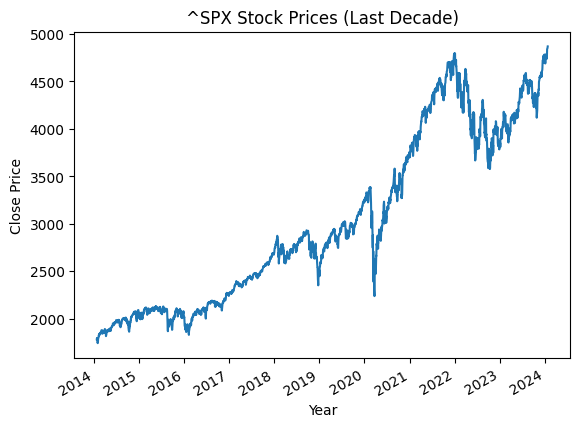

In [122]:
# plot prices in plot
prices.plot(title=f'{ticker} Stock Prices (Last Decade)')
plt.xlabel('Year')
plt.ylabel('Close Price')
plt.show()

In [123]:
# scale date to between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))

prices = prices.values.reshape(-1, 1)
prices = scaler.fit_transform(prices)

# Train Test Split
The train and test sets will be split into the following:

1. The training set will be the first 7 years.
2. The testing set will be the past 3 years.

In [124]:
# run train test split
split_point = round(0.7 * len(prices))
train_set = prices[:split_point]
test_set = prices[split_point:]

## Split training and testing sets into features and targets

In [125]:
# split sets into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
		
	return np.array(X), np.array(y)

# run train and testing set through split_sequence
n_steps = 365

X_train, y_train = split_sequence(train_set, n_steps)
X_test, y_test = split_sequence(test_set, n_steps)

# Initialize CNN and Train Model

In [126]:
# initialize model
model = Sequential()

# add 1D convolutional layer with 64 filters
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, 1)))

# add a max pooling layer
model.add(MaxPooling1D(pool_size=2))

# flatten then add a dense layer
model.add(Flatten())
model.add(Dense(50, activation='relu'))

# add an output layer
model.add(Dense(1))

# compoile the model
model.compile(optimizer='adam', loss='mse')

In [127]:
# train model with training set
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=False)

In [128]:
# make predictions for both training and testing data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

13/13 [==============================] - 0s 4ms/step


# Calculate RMSE

In [129]:
# calculate RMSE for train set and test set predictions

# calculate train score
train_score = np.sqrt(mean_squared_error(y_train, train_predict))
print('Train Score: %.2f RMSE' % (train_score))

# calculate test score
test_score = np.sqrt(mean_squared_error(y_test, test_predict))
print('Test Score: %.2f RMSE' % (test_score))

Train Score: 0.03 RMSE
Test Score: 0.10 RMSE


In [130]:
# inverse transform train and test predictions back to original prices
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

Visualize Actual Prices vs Train Predictions and Test Predictions

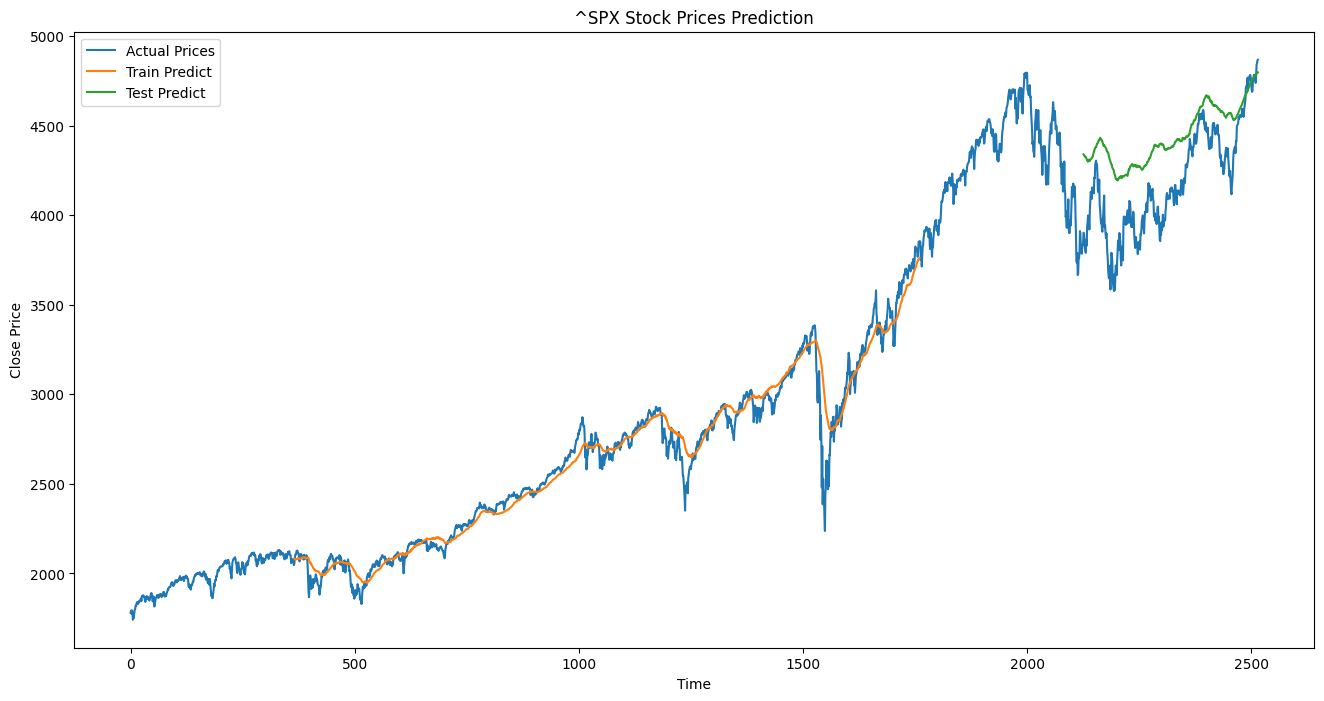

In [131]:
# plot original prices
plt.figure(figsize=(16,8))
plt.plot(scaler.inverse_transform(prices), label='Actual Prices')

# plot training set prediction
trainPredictPlot = np.empty_like(prices)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[n_steps:len(train_predict)+n_steps, :] = train_predict
plt.plot(trainPredictPlot, label='Train Predict')

# plot testing set prediction
testPredictPlot = np.empty_like(prices)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(n_steps*2):len(prices):] = test_predict
plt.plot(testPredictPlot, label='Test Predict')

plt.title(f'{ticker} Stock Prices Prediction')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Create Forecast

In [134]:
# retrain model on all data, both training and testing set
X, y = split_sequence(prices, n_steps)
model.fit(X, y, epochs=10, batch_size=100, verbose=False)

In [137]:
# Generate a sequence for the next 2 years
forecast_period = 365 * 2
forecast_sequence = prices[-n_steps:].flatten()

# Make predictions for the next 2 years
for i in range(forecast_period):
    # Reshape the input sequence for prediction
    forecast_input = forecast_sequence[-n_steps:].reshape(1, n_steps, 1)
    
    # Use the trained model to predict the next data point
    next_prediction = model.predict(forecast_input, verbose=False)
    
    # Append the prediction to the sequence
    forecast_sequence = np.append(forecast_sequence, next_prediction)

# Inverse transform the forecast sequence to get original prices
forecast_sequence = forecast_sequence.reshape(-1, 1)
forecast_sequence = scaler.inverse_transform(forecast_sequence)

# Visualization for Historical Prices and Forecast

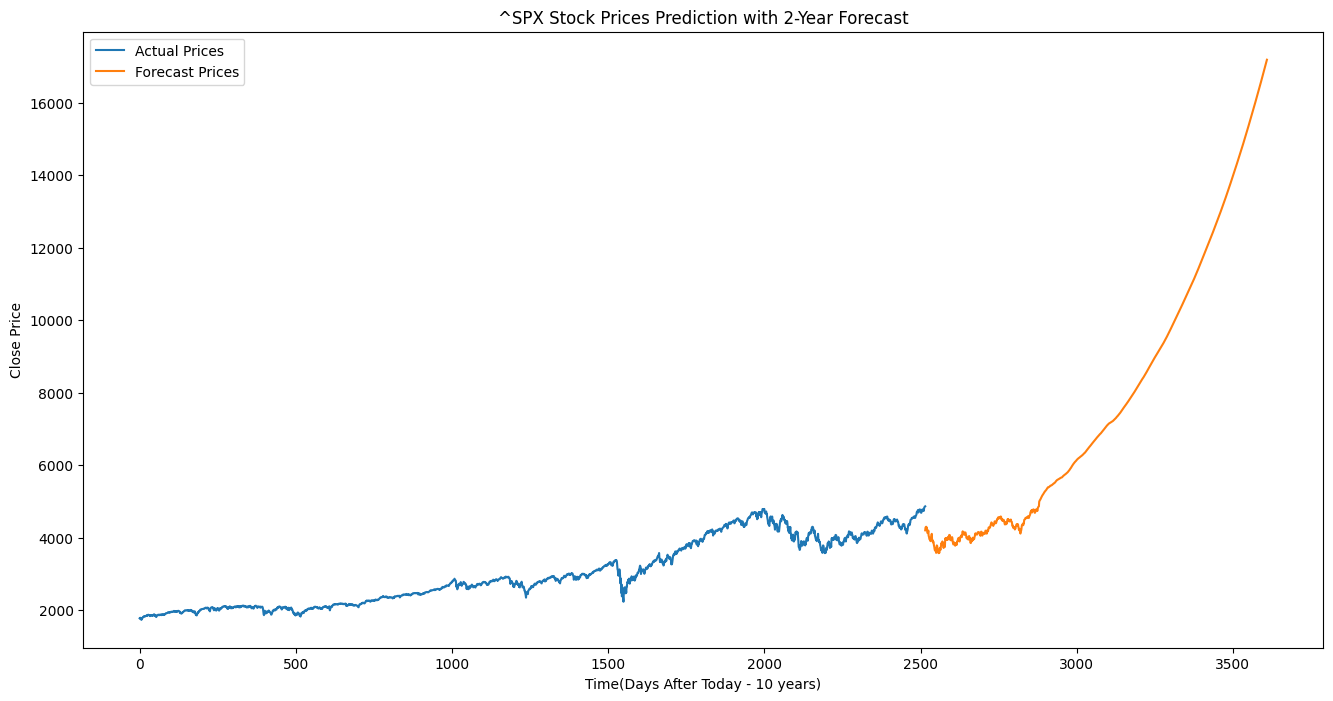

In [140]:
# Plot the original prices and forecast
plt.figure(figsize=(16, 8))
plt.plot(scaler.inverse_transform(prices), label='Historical Prices')

# set forecast price range and plot forecast prices
forecast_range = range(len(prices)-1, len(prices)+len(forecast_sequence)-1)
plt.plot(forecast_range, forecast_sequence, label='Forecast Prices')

# add labels and legend
plt.title(f'{ticker} Stock Prices Prediction with 2-Year Forecast')
plt.xlabel('Time(Days After Today - 10 years)')
plt.ylabel('Close Price')
plt.legend()
plt.show()